Steps in Creating a Fruits Recognition Model
*   Import libraries
*   Connect Google Colab to Kaggle and Download dataset
*   Load the images into training and validation set
*   Inspect the shape
*   Build the model: by rescaling, using conv2d layer, max2d pooling, flatten and the output dense layer.
*   Using 'relu' as the activation function for each layer, 'SparseCategoricalEntropy' as loss function and 'sigmoid' as activation for output layer.
*   

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pathlib import Path
import os
import tensorflow as tf

In [2]:
 from google.colab import files
 files.upload()

Saving kaggle.json to kaggle (2).json


{'kaggle.json': b'{"username":"vikthour","key":"854772165a20adf6b63b62f944d1936f"}'}

In [3]:
# Create a kaggle folder
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
# Copy the kaggle.json file into the /.kaggle folder
! cp kaggle.json ~/.kaggle/

In [5]:
# Permission for the json to be executed.

!chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download -d kritikseth/fruit-and-vegetable-image-recognition -p Dataset

fruit-and-vegetable-image-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
#!unzip Dataset/fruit-and-vegetable-image-recognition.zip

Archive:  Dataset/fruit-and-vegetable-image-recognition.zip
replace test/apple/Image_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
# Select the directory
fruits_veg_dir_train = Path('/content/train/')
fruits_veg_dir_val = Path('/content/validation/')
fruits_veg_dir_test = Path('/content/test/')

# Create the filepath using the directory
train_filepaths = list(fruits_veg_dir_train.glob(r'**/*.jpg'))
val_filepaths = list(fruits_veg_dir_val.glob(r'**/*.jpg'))
test_filepaths = list(fruits_veg_dir_test.glob(r'**/*.jpg'))

# Select the labels
train_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], train_filepaths))
val_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], val_filepaths))
test_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], test_filepaths))

# Paths and Labels for the trainset
train_filepaths = pd.Series(train_filepaths, name='File').astype(str)
train_labels = pd.Series(train_labels, name='Label')

# Paths and Labels for the valset
val_filepaths = pd.Series(train_filepaths, name='File').astype(str)
val_labels = pd.Series(val_labels, name='Label')

# Paths and Labels for the testset
test_filepaths = pd.Series(test_filepaths, name='File').astype(str)
test_labels = pd.Series(test_labels, name= 'File')

# Concatenating both the paths and labels for train
train_df = pd.concat([train_filepaths, train_labels], axis=1)

# Concatenating both the paths and labels for val
val_df = pd.concat([val_filepaths, val_labels], axis=1)

# Concatenating both the paths and labels for test
test_df = pd.concat([test_filepaths, test_labels], axis= 1)

train_df = train_df.sample(frac=1, random_state = 42).reset_index(drop= True)
val_df = val_df.sample(frac=1, random_state= 42).reset_index(drop= True)
test_df = test_df.sample(frac=1, random_state= 42).reset_index(drop= True)

In [9]:
train_df.head(2)

,File,Label
0,/content/train/sweetcorn/Image_63.jpg,sweetcorn
1,/content/train/sweetcorn/Image_73.jpg,sweetcorn


In [10]:
test_df.head(2)

,File,File
0,/content/test/cabbage/Image_2.jpg,cabbage
1,/content/test/jalepeno/Image_9.jpg,jalepeno


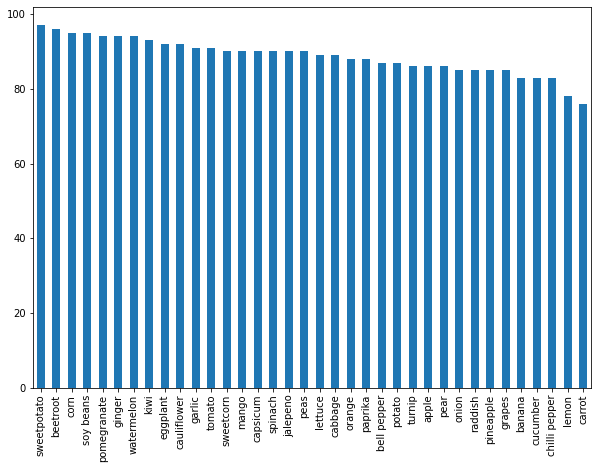

In [11]:
plt.figure(figsize=(10, 7))
train_df.Label.value_counts().plot(kind='bar')

In [12]:
train_df.Label.nunique()

36

In [13]:
plt.style.use('dark_background')

Text(0.5, 0, '(1074, 2093, 3)')

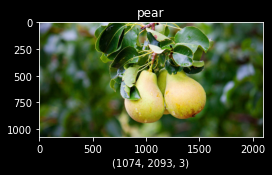

In [14]:
plt.figure(figsize=(4, 4))
x = plt.imread(train_df['File'][20])
plt.imshow(x)
plt.title(train_df.Label[20])
plt.xlabel(x.shape)

<Figure size 720x720 with 0 Axes>

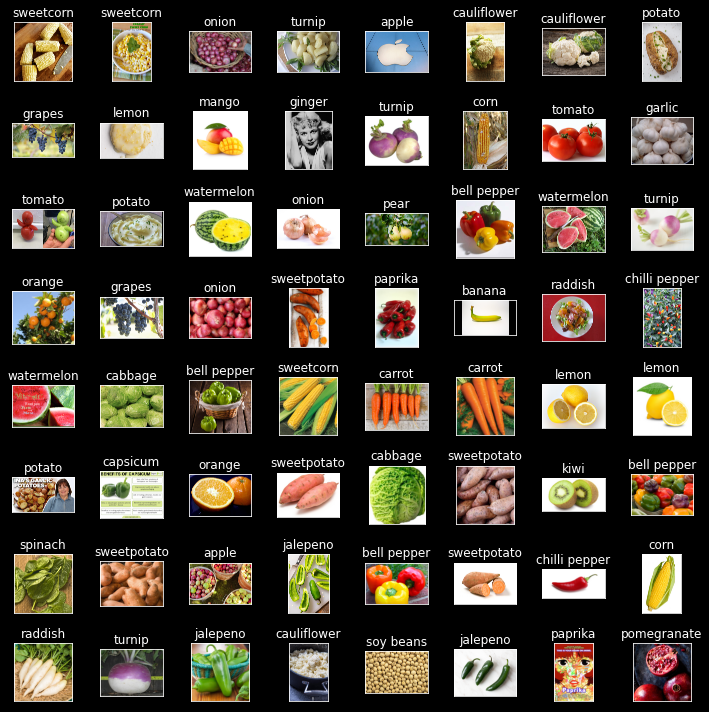

In [15]:
plt.figure(figsize=(10, 10))
fig, axes = plt.subplots(8, 8, figsize=(10, 10),
                         subplot_kw = {"xticks": [], "yticks": []})

for i, ax in enumerate(axes.flat):
  ax.imshow(plt.imread(train_df['File'][i]))
  ax.set_title(train_df['Label'][i])
plt.tight_layout()
plt.show()

In [16]:
batch_size = 32
image_height = 256
image_width = 256

In [17]:
train_set = tf.keras.preprocessing.image_dataset_from_directory(fruits_veg_dir_train, seed= 42, 
                                                                image_size= (image_height, image_width), 
                                                                batch_size = batch_size)

val_set = tf.keras.preprocessing.image_dataset_from_directory(fruits_veg_dir_val, seed= 42,
                                                              image_size= (image_height, image_width),
                                                              batch_size = batch_size)

test_set = tf.keras.preprocessing.image_dataset_from_directory(fruits_veg_dir_test, seed=42, 
                                                               image_size=(image_height, image_width),
                                                               batch_size= batch_size)

Found 3581 files belonging to 36 classes.
Found 351 files belonging to 36 classes.
Found 359 files belonging to 36 classes.


In [18]:
train_set.class_names, len(train_set.class_names)

(['apple',
  'banana',
  'beetroot',
  'bell pepper',
  'cabbage',
  'capsicum',
  'carrot',
  'cauliflower',
  'chilli pepper',
  'corn',
  'cucumber',
  'eggplant',
  'garlic',
  'ginger',
  'grapes',
  'jalepeno',
  'kiwi',
  'lemon',
  'lettuce',
  'mango',
  'onion',
  'orange',
  'paprika',
  'pear',
  'peas',
  'pineapple',
  'pomegranate',
  'potato',
  'raddish',
  'soy beans',
  'spinach',
  'sweetcorn',
  'sweetpotato',
  'tomato',
  'turnip',
  'watermelon'],
 36)

In [19]:
class_names = train_set.class_names

In [20]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [21]:
num_classes = len(train_set.class_names)
model = tf.keras.Sequential([
                             tf.keras.layers.Rescaling(1./255),
                             tf.keras.layers.Conv2D(32, 3, activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Conv2D(32, 3, activation='relu'),
                             tf.keras.layers.MaxPool2D(),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128, activation= 'relu'),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(64, activation='relu'),
                             tf.keras.layers.Dense(36, activation='softmax')

])

model.compile(loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy'])

history = model.fit(train_set, validation_data= val_set, epochs = 10)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


112/112 [==============================] - 295s 3s/step - loss: 3.4331 - accuracy: 0.0659 - val_loss: 3.0893 - val_accuracy: 0.0969
Epoch 2/10
112/112 [==============================] - 293s 3s/step - loss: 3.0967 - accuracy: 0.1304 - val_loss: 2.6326 - val_accuracy: 0.3048
Epoch 3/10
112/112 [==============================] - 292s 3s/step - loss: 2.6135 - accuracy: 0.2712 - val_loss: 1.4764 - val_accuracy: 0.6667
Epoch 4/10
112/112 [==============================] - 293s 3s/step - loss: 1.6246 - accuracy: 0.5376 - val_loss: 0.6512 - val_accuracy: 0.8661
Epoch 5/10
112/112 [==============================] - 294s 3s/step - loss: 0.7681 - accuracy: 0.7900 - val_loss: 0.3162 - val_accuracy: 0.9231
Epoch 6/10
112/112 [==============================] - 294s 3s/step - loss: 0.3751 - accuracy: 0.9090 - val_loss: 0.2337 - val_accuracy: 0.9516
Epoch 7/10
112/112 [==============================] - 294s 3s/step - loss: 0.2140 - accuracy: 0.9447 - val_loss: 0.1529 - val_accuracy: 0.9772
Epoch 8/10

In [22]:
model.summary

<bound method Model.summary of <keras.engine.sequential.Sequential object at 0x7fa9dfe78950>>

In [23]:
model.evaluate(test_set)

12/12 [==============================] - 14s 613ms/step - loss: 0.0314 - accuracy: 0.9833


[0.03139827772974968, 0.9832869172096252]

The accuracy of the model in predicting on the test set is 98.3%. That's pretty good enough.

In [ ]:
test_set

In [ ]:
image_file = '/content/test/cauliflower/Image_10.jpg'

image = tf.keras.preprocessing.image.load_img(image_file, target_size=(image_height, image_width))
plt.imshow(image)
plt.show()
x = tf.keras.preprocessing.image.img_to_array(image)
x = np.expand_dims(x, axis = 0)

images = np.vstack([x])
pred = model.predict(images, batch_size=32)
label = np.argmax(pred, axis= 1)
print("Actual: " + image_file.split("/")[-2])
print("Predicted: " + class_names[np.argmax(pred)])

features = model.predict(x)

### Save the Model

In [26]:
model.save('Fruits_and_veggies_recognition_model')

INFO:tensorflow:Assets written to: Fruits_and_veggies_recognition_model/assets


In [27]:
model.save('Fruits_and_veggies_recognition_model.h5')